In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [2]:
train_data = datasets.FashionMNIST(root = "data",
                                   train = True,
                                   download = True,
                                   transform = ToTensor(),
                                   target_transform = None)
test_data = datasets.FashionMNIST(root = "data",
                                  train = False,
                                  download = True,
                                  transform = ToTensor(),
                                  target_transform = None)

Text(0.5, 1.0, '9')

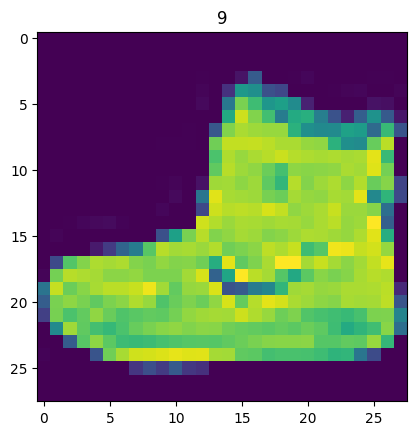

In [3]:
import matplotlib.pyplot as plt
image, label = train_data[0]
plt.imshow(image.squeeze())
plt.title(label)

In [4]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

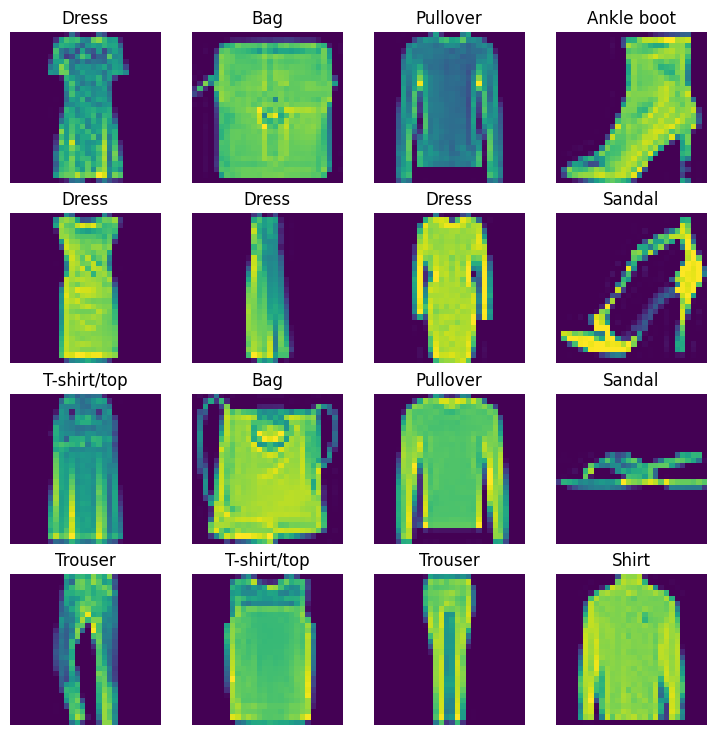

In [5]:
fig = plt.figure(figsize = (9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size = (1,)).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze())
    plt.title(class_names[label])
    plt.axis(False)

In [6]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# Turn datasets into iterables / batches
train_dataloader = DataLoader(train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)
test_dataloader = DataLoader(test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

In [7]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [8]:
# Test out flatten layer
flatten_model = nn.Flatten()
x = train_features_batch[0]
print(x.shape)
output = flatten_model(x) # [color_channels, height*width]
print(output.shape)

torch.Size([1, 28, 28])
torch.Size([1, 784])


In [9]:
tens = torch.randn([2,3,4,5])
print(flatten_model(tens).shape)

torch.Size([2, 60])


In [10]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    def forward(self, x):
        return self.layer_stack(x)

In [11]:
device = "mps"
model_0 = FashionMNISTModelV0(input_shape=28*28,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
next(model_0.parameters()).device

device(type='mps', index=0)

In [12]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


helper_functions.py already exists, skipping download


In [13]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [14]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [15]:
from tqdm.auto import tqdm

train_time_start_on_cpu = timer()
model_0.to("cpu")
epochs = 3

# Training
for epoch in tqdm(range(epochs)):
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"At batch: {batch} out of a total of {len(train_dataloader)} batches")
    loss /= len(train_dataloader)

    # Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true = y,
                                    y_pred = test_pred.argmax(dim = 1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    print(f"\nTrain loss: {train_loss} | Test loss: {test_loss}, Test acc: {test_acc}%\n")
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

At batch: 0 out of a total of 1875 batches
At batch: 400 out of a total of 1875 batches
At batch: 800 out of a total of 1875 batches
At batch: 1200 out of a total of 1875 batches
At batch: 1600 out of a total of 1875 batches

Train loss: 1772.3988037109375 | Test loss: 0.7286745309829712, Test acc: 76.04832268370608%

At batch: 0 out of a total of 1875 batches
At batch: 400 out of a total of 1875 batches
At batch: 800 out of a total of 1875 batches
At batch: 1200 out of a total of 1875 batches
At batch: 1600 out of a total of 1875 batches

Train loss: 1270.05615234375 | Test loss: 0.7031522393226624, Test acc: 77.04672523961662%

At batch: 0 out of a total of 1875 batches
At batch: 400 out of a total of 1875 batches
At batch: 800 out of a total of 1875 batches
At batch: 1200 out of a total of 1875 batches
At batch: 1600 out of a total of 1875 batches

Train loss: 1207.9739990234375 | Test loss: 0.656514585018158, Test acc: 77.98522364217253%

Train time on cpu: 6.963 seconds


In [16]:
# Functionizing training and testing loops
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    model.to(device)
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [17]:
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
device = "mps"
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_0, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_0,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.62668 | Train accuracy: 78.59%
Test loss: 0.68974 | Test accuracy: 76.26%

Epoch: 1
---------
Train loss: 0.44257 | Train accuracy: 84.30%
Test loss: 0.47396 | Test accuracy: 82.72%

Epoch: 2
---------
Train loss: 0.41275 | Train accuracy: 85.13%
Test loss: 0.44226 | Test accuracy: 84.58%

Train time on mps: 16.253 seconds


In [18]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    model.to(device)
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [19]:
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device="mps"
)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.44225776195526123,
 'model_acc': 84.58466453674122}

In [20]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,
                         stride = 2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units,
                      out_channels = hidden_units,
                      kernel_size = 3,
                      stride = 1,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2,
                         stride = 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units * 49,
                      out_features = output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        #print(f"x's shape at the end of block 1: {x.shape}")
        x = self.block_2(x)
        #print(f"x's shape at the end of block 2: {x.shape}")
        x = self.classifier(x)
        #print(x.shape)
        return x

In [21]:
model_2 = FashionMNISTModelV2(input_shape = 1,
                              hidden_units = 10,
                              output_shape = len(class_names))
model_2.to("mps")
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [22]:
# test out what should the dimension be when passed into "classifier flatten()"
test_image = torch.rand(size = (32,1,28,28)).to("mps")
model_2(test_image)

tensor([[ 0.0263,  0.0101, -0.0131, -0.0277,  0.0303, -0.0476,  0.0348, -0.0284,
          0.0586, -0.0173],
        [ 0.0277,  0.0070, -0.0119, -0.0301,  0.0325, -0.0440,  0.0374, -0.0363,
          0.0542, -0.0141],
        [ 0.0232,  0.0100, -0.0127, -0.0224,  0.0334, -0.0447,  0.0374, -0.0378,
          0.0500, -0.0153],
        [ 0.0240,  0.0117, -0.0143, -0.0285,  0.0338, -0.0439,  0.0274, -0.0319,
          0.0530, -0.0145],
        [ 0.0304,  0.0117, -0.0162, -0.0333,  0.0366, -0.0516,  0.0314, -0.0274,
          0.0470, -0.0178],
        [ 0.0277,  0.0115, -0.0173, -0.0247,  0.0327, -0.0520,  0.0241, -0.0333,
          0.0537, -0.0183],
        [ 0.0300,  0.0075, -0.0162, -0.0286,  0.0338, -0.0508,  0.0257, -0.0266,
          0.0566, -0.0166],
        [ 0.0320,  0.0077, -0.0090, -0.0305,  0.0335, -0.0498,  0.0300, -0.0290,
          0.0520, -0.0126],
        [ 0.0245,  0.0101, -0.0112, -0.0221,  0.0359, -0.0497,  0.0348, -0.0319,
          0.0583, -0.0231],
        [ 0.0293,  

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

In [30]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device="mps"
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device="mps"
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device="mps")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.21008 | Train accuracy: 92.24%
Test loss: 0.27792 | Test accuracy: 90.18%

Epoch: 1
---------
Train loss: 0.21010 | Train accuracy: 92.22%
Test loss: 0.27082 | Test accuracy: 90.57%

Epoch: 2
---------
Train loss: 0.20991 | Train accuracy: 92.34%
Test loss: 0.28210 | Test accuracy: 90.12%

Train time on mps: 22.690 seconds


In [31]:
# Get model_2 results 
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.28209713101387024,
 'model_acc': 90.11581469648563}

In [33]:
model_0_results, model_2_results

({'model_name': 'FashionMNISTModelV0',
  'model_loss': 0.44225776195526123,
  'model_acc': 84.58466453674122},
 {'model_name': 'FashionMNISTModelV2',
  'model_loss': 0.28209713101387024,
  'model_acc': 90.11581469648563})

In [35]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.442258,84.584665
1,FashionMNISTModelV2,0.282097,90.115815


In [37]:
compare_results["training_time"] = [total_train_time_model_0, total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.442258,84.584665,6.963493
1,FashionMNISTModelV2,0.282097,90.115815,22.690302


In [52]:
# Make & evaluate random predictions with best model
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = "mps"):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim = 0) # need to add batch dimension
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [71]:
import random
random.seed(42)

# test_samples with the correct test_labels
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
# -------------------------------------------------------------
#test_samples with the predicted test_labels, called "pred_classes"
pred_probs = make_predictions(model = model_2.to("cpu"),
                              data = test_samples)
pred_classes = pred_probs.argmax(dim = 1)
pred_classes, test_labels, pred_classes.tolist() == test_labels

(tensor([5, 1, 7, 2, 3, 0, 4, 7, 1]), [5, 1, 7, 4, 3, 0, 4, 7, 1], False)

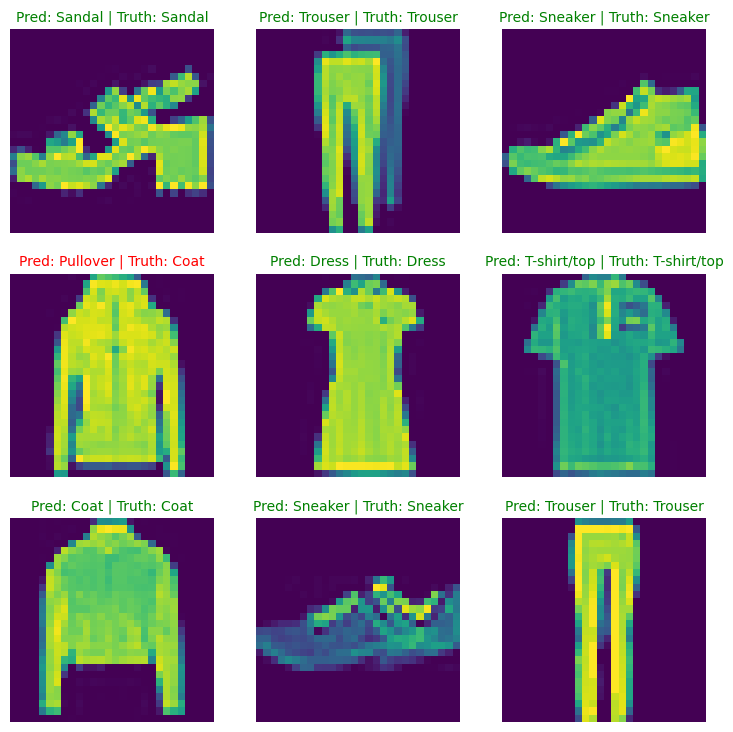

In [72]:
# Visualize the above predictions

plt.figure(figsize = (9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze())
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
    plt.axis(False);

In [ ]:
# Confusion Matrix
w